# TP5 Attaques adversaires

Dans ce TP, nous allons aborder la robustesse sous l'angle de l'attaque adverse. L'idée est de réussir à tromper un réseau de neurones déjà entraîné en ajoutant une variation de faible amplitude à une image. Dans les deux premières parties, nous verrons comment tromper un classifieur entraîné sur Imagenet. La dernière partie est consacrée à l'entraînement d'un classifieur qui soit robuste aux attaques adverses.

## Partie 1 : Création d'un exemple adversaire

Un classifieur est typiquement entraîné pour minimiser le risque empirique associé à une certaine fonction de coût ou *loss* $l$ sur l'ensemble des données d'entraînement $\{(x_i,y_i)\}$  avec $x_i$ les données d'entrée et $y_i$ les labels. Tromper un classifieur donné revient donc à ajouter à l'entrée $x$ une pertubation $\delta$ pour s'assurer que l'exemple généré soit associé à une valeur élevée de la loss : 

$$\hat\delta = \underset{\delta \in \Delta}{\text{argmax}\,} l(h_\theta(x+\delta),y).$$

$h_\theta$ est le modèle de paramètres $\theta$ que nous essayons de duper. L'ensemble $\Delta$ représente les perturbations admises. Celui-ci est généralement défini par une contrainte associée à la magnitude de la perturbation *ie.* on cherche avant tout des perturbations *relativement* indécelable pour un humain et qui ne transforment pas l'image de façon évidente. Dans ce contexte, on peut prendre

$$\Delta = \{\delta : ||\delta||_{\infty}\leq\epsilon\}.$$

La façon la plus simple de trouver un exemple adversaire est donc de faire une *montée* de gradient selon la fonction:

$$ \delta \rightarrow l(h_\theta(x+\delta),y).$$

La contrainte d'apartenance à $\Delta$ est assurée en écrétant les valeur de $\delta$ pour que chaque coefficient soit de magnitude inférieure à $\epsilon$.

Pour commencer, téléchargeons et observons l'image sur laquelle nous allons travailler:


In [ ]:
!wget https://adversarial-ml-tutorial.org/introduction/pig.jpg

--2022-06-07 20:10:34--  https://adversarial-ml-tutorial.org/introduction/pig.jpg
Resolving adversarial-ml-tutorial.org (adversarial-ml-tutorial.org)... 185.199.110.153, 185.199.108.153, 185.199.111.153, ...
Connecting to adversarial-ml-tutorial.org (adversarial-ml-tutorial.org)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 56267 (55K) [image/jpeg]
Saving to: ‘pig.jpg’

pig.jpg             100%[===================>]  54.95K  --.-KB/s    in 0.01s   

2022-06-07 20:10:34 (5.00 MB/s) - ‘pig.jpg’ saved [56267/56267]



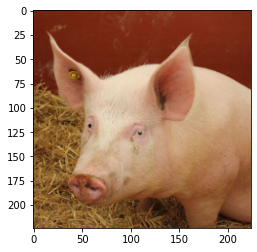

In [ ]:
from PIL import Image
from torchvision import transforms
from matplotlib import pyplot as plt

# read the image, resize to 224 and convert to PyTorch Tensor
pig_img = Image.open("pig.jpg")
preprocess = transforms.Compose([
   transforms.Resize(224),
   transforms.ToTensor(),
])
pig_tensor = preprocess(pig_img)[None,:,:,:]

# plot image (note that numpy using HWC whereas Pytorch user CHW, so we need to convert)
plt.imshow(pig_tensor[0].numpy().transpose(1,2,0))


Le but de cette première partie est donc de réussir à faire croire à  notre modèle que ce cochon est en réalité *autre chose* (une image d'une autre classe). Le modèle que nous choississons ici est un resnet50 pré-entraîné sur Imagenet.

In [ ]:
import torch
import torch.nn as nn
from torchvision.models import resnet50

# simple Module to normalize an image
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.Tensor(mean)
        self.std = torch.Tensor(std)
    def forward(self, x):
        return (x - self.mean.type_as(x)[None,:,None,None]) / self.std.type_as(x)[None,:,None,None]

# values are standard normalization for ImageNet images, 
# from https://github.com/pytorch/examples/blob/master/imagenet/main.py
norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# load pre-trained ResNet50, and put into evaluation mode (necessary to e.g. turn off batchnorm)
model = resnet50(pretrained=True)
model.eval();


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
!wget http://cedric.cnam.fr/~rambourc/imagenet_class_index.json

--2022-06-07 20:12:51--  http://cedric.cnam.fr/~rambourc/imagenet_class_index.json
Resolving cedric.cnam.fr (cedric.cnam.fr)... 163.173.128.10
Connecting to cedric.cnam.fr (cedric.cnam.fr)|163.173.128.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/json]
Saving to: ‘imagenet_class_index.json’

imagenet_class_inde 100%[===================>]  34.53K  --.-KB/s    in 0.09s   

2022-06-07 20:12:51 (388 KB/s) - ‘imagenet_class_index.json’ saved [35363/35363]



Nous pouvons vérifier en guise de préliminaire que le modèle classe l'image dans la bonne catégorie:

In [ ]:
pred = model(norm(pig_tensor))
import json
with open("imagenet_class_index.json") as f:
    imagenet_classes = {int(i):x[1] for i,x in json.load(f).items()}
print(imagenet_classes[pred.max(dim=1)[1].item()])


hog


#### Coding Task

Implémenter la montée de gradient pour transformer subtilement ce cochon et tromper le classifieur pré-entraîné. La loss utilisée pour l'entraînement du modèle était la *cross-entropy loss* donnée par la méthode `nn.CrossEntropy(y_predit, y)`. L'index associé à la classe `hog` est `341`.

In [ ]:
import torch.optim as optim
epsilon = 2./255

delta = torch.zeros_like(pig_tensor, requires_grad=True)
opt = optim.SGD([delta], lr=1e-1)

for t in range(30):
    pred = model(norm(pig_tensor + delta))

    ## Your code here ######
    loss = # Adverserial Loss

    
    if t % 5 == 0:
        print(t, loss.item())
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon, epsilon)
    
print("True class probability:", nn.Softmax(dim=1)(pred)[0,341].item())


0 -0.003882253309711814
5 -0.006934622768312693
10 -0.015811428427696228
15 -0.08034618943929672
20 -11.94543170928955
25 -15.1060209274292
True class probability: 4.810103746422101e-07


In [ ]:
max_class = pred.max(dim=1)[1].item()
print("Predicted class: ", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())


Notre réseau de neurones prend à présent l'image modifiée pour une instance de la classe wombat. Pourtant avons-nous tellement modifié cette image ? En réalité, le changement est imperceptible pour un humain : 

In [ ]:
plt.imshow((pig_tensor + delta)[0].detach().numpy().transpose(1,2,0))

## Partie 2 : Attaque ciblée

Il peut sembler plus intéressant de tromper le modèle de manière plus contrôlé en modifiant l'entrée pour la rendre détectable comme une classe de notre choix. Pourquoi se limiter aux wombats quand Imagenet à 1000 classes ? Pour faire croire à $h_\theta$ que $x + \delta$ est à peu près n'importe quoi, tout ce que nous avons à faire est de maximiser la loss pour la vraie classe $y$ *ie. hog* et la minimiser pour la classe d'intérêt $y_{\text{target}}$ *eg. airliner*:

$$\hat \delta = \underset{\delta \in \Delta}{\text{argmax}} \bigl( l(h_\theta(x+\delta), y) - l(h_\theta(x+\delta), y_{\text{target}}) \bigr)$$

En incluant l'activation de type *softmax* directement dans la loss, on a de plus la simplification suivante:

\begin{align}
\hat \delta &= \underset{\delta \in \Delta}{\text{argmax}} \bigl( \log \frac{\exp{h_{\theta}(x+\delta)_y}}{\sum_j \exp{h_{\theta}(x)_j}} - \log \frac{\exp{h_{\theta}(x+\delta)_{y_{\text{target}}}}}{\sum_j \exp{h_{\theta}(x)_j}} \bigr) \\
&= \underset{\delta \in \Delta}{\text{argmax}} \bigl( h_{\theta}(x+\delta)_y - h_{\theta}(x+\delta)_{y_{\text{target}}}\bigr)
\end{align}



### Coding task

Implémenter la montée de gradient pour tromper le modèle et lui faire classifier l'image comme un avion soit de la classe donnée par l'index `404`. 

In [ ]:
delta = torch.zeros_like(pig_tensor, requires_grad=True)
opt = optim.SGD([delta], lr=5e-3)

for t in range(100):
    pred = model(norm(pig_tensor + delta))

    ## Your code here ######
    loss = # Targeted Adverserial Loss 

    
    if t % 10 == 0:
        print(t, loss.item())
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon, epsilon)


0 24.00604820251465
10 -0.15508747100830078
20 -7.620338439941406
30 -14.787199020385742
40 -21.15138816833496
50 -25.89435386657715
60 -30.196027755737305
70 -34.96584701538086
80 -38.666412353515625
90 -38.255027770996094


In [ ]:
max_class = pred.max(dim=1)[1].item()
print("Predicted class: ", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())


## Pour aller plus loin :  entraîner un modèle robuste

Dans cette partie, nous allons voir comment entraîner un classifieur pour le rendre robuste à ce genre d'attaques adverses. Pour ce faire nous allons préalablement entraîner un modèle à classifier les images de la base mnist. Puis, nous comparerons ce modèle appris en minimisant une loss de cross-entropy avec un modèle robuste minimisant le risque empirique maximal.

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

mnist_train = datasets.MNIST("../data", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST("../data", train=False, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(mnist_train, batch_size = 100, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size = 100, shuffle=False)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



Pour que notre modèle soit robuste aux attaques adversaires, nous devons faire en sorte que sa fonction de coût soit minimale **même** dans le cas d'attaque. Mis bout à bout, cela reviens donc à minimiser la pire erreur faite sur l'ensemble des perturbations autorisées:

$$l_{\text{robuste}}(x,y) = \frac{1}{N} \sum_{i=1}^N \underset{\delta \in \Delta(x)}{\max\,} l(h_\theta(x + \delta),y).$$ 

Une étape de descente de gradient sur un batch $B$ est donc donnée par:

$$\theta \leftarrow θ - \frac{\alpha}{|B|} \sum_{(x,y)\in B} ∇_θ \underset{\delta \in \Delta(x)}{\max\,} l(h_\theta(x + \delta),y).$$

D'après le théorème de Dankin, ceci est équivalent à :
$$\theta \leftarrow θ - \frac{\alpha}{|B|} \sum_{(x,y)\in B} ∇_θ  l(h_\theta(x + \delta^*),y),$$

où $\delta^* = \underset{δ∈Δ(x)}{\text{argmax }} l(h_\theta(x+\delta),y)$ est la perturbation maximisant la loss. L'apprentissage comporte donc à présent un double problème d'optimisation :
* Maximiser par rapport à la perturbation $\delta$
* Minimiser par rapport à  aux paramètres du modèle $\theta$.

Le second point est commun à toute approche d'apprentissage. Nous allons nous attarder sur le problème de maximisation.

### Fast Gradient Sign Method (FGSM)

Une manière que nous connaissons bien de trouver un extremum est de se déplacer selon la direction du gradient de la fonction à optimiser. Soit $g = ∇_δ l(h_\theta(x+\delta),y)$. Pour maximiser la loss d'attaque, nous devons donc faire un pas dans la direction $g$ mais également respecter la contrainte d'avoir $\delta \in \Delta$. Par ailleurs, nous choisirons l'initialisation raisonnable $\delta_{\text{init}} = 0$. La transformation de $\delta$ par montée de gradient est donc:

$$\delta ← \text{clip}(\delta_{\text{init}} + \alpha g,[-\epsilon,\epsilon]) = \text{clip}(\alpha g,[-\epsilon,\epsilon]),$$

où la fonction $\text{clip}(x,[-\epsilon,\epsilon])$ permet d'écréter les valeurs de $x$ de magnitude supérieur à $\epsilon$. Par définition $\epsilon \lll 1$ et il est donc attendu que la mise à jour de $\delta$ sature. Une approximation simple permettant de s'affranchir de trouver un pas de gradient idéal est donc:

$$\delta = \epsilon . \text{sign}(g).$$
Cette méthode est connue sous le nom de *Fast Gradient Sign Method* (FGSM) et est classiquement utilisée dans une grande variété d'approches adversaires.


### Projected Gradient Descent (PGD)

Bien que FGSM soit simple et rapide à calculer, si l'on dispose de ressources suffisantes pour faire plusieurs étape de montée de gradient, l'estimation de $\delta^*$ n'en est que meilleure. Dans ce cas, le calcul de $\delta^*$ est donnée par plusieurs itérations de montée de gradient:

$$\delta ← \text{clip}(\delta_{\text{init}} + \alpha g,[-\epsilon,\epsilon]).$$

Dans ce cas $\alpha$ et le nombre d'itérations restent des hyper-paramètres à régler. **NB** L'opérateur de projection est donné par une opération de *clipping* ou écrétage mais pourrait prendre une autre forme selon la norme utilisée dans la contrainte imposée à $\delta$.



### Implémentation

Les fonctions suivantes implémentent les deux méthodes de mises à jour FGSM et PGD. 



### Coding Task

Compléter les fonction de montée de gradient

In [ ]:
def fgsm(model, X, y, epsilon=0.1):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)

    ## Your code here ######
    loss = # Adverserial loss

    loss.backward()

    ## Your code here ######
    epsilon = # Clipping
    
    return epsilon 
def pgd_linf(model, X, y, epsilon=0.1, alpha=0.01, num_iter=20, randomize=False):
    """ Construct FGSM adversarial examples on the examples X"""
    if randomize:
        delta = torch.rand_like(X, requires_grad=True)
        delta.data = delta.data * 2 * epsilon - epsilon
    else:
        delta = torch.zeros_like(X, requires_grad=True)
        
    for t in range(num_iter):

        ## Your code here ######
        loss = # Adverserial loss

        loss.backward()

        ## Your code here ######
        delta.data = # Gradient ascent update

        delta.grad.zero_()
    return delta.detach()


Les deux fonctions suivantes implémentent les boucles d'apprentissage avec et sans attaque :

In [ ]:
def epoch(loader, model, opt=None):
    """Standard training/evaluation epoch over the dataset"""
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        yp = model(X)
        loss = nn.CrossEntropyLoss()(yp,y)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)


def epoch_adversarial(loader, model, attack, opt=None, **kwargs):
    """Adversarial training/evaluation epoch over the dataset"""
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        delta = attack(model, X, y, **kwargs)
        yp = model(X+delta)
        loss = nn.CrossEntropyLoss()(yp,y)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)


Nous utiliserons la même architecture pour le modèle standard et le modèle robuste :

In [ ]:
torch.manual_seed(0)


model_cnn = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(32, 32, 3, padding=1, stride=2), nn.ReLU(),
                          nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(64, 64, 3, padding=1, stride=2), nn.ReLU(),
                          nn.Flatten(),
                          nn.Linear(7*7*64, 100), nn.ReLU(),
                          nn.Linear(100, 10)).to(device)

model_cnn_robust = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
                                 nn.Conv2d(32, 32, 3, padding=1, stride=2), nn.ReLU(),
                                 nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
                                 nn.Conv2d(64, 64, 3, padding=1, stride=2), nn.ReLU(),
                                 nn.Flatten(),
                                 nn.Linear(7*7*64, 100), nn.ReLU(),
                                 nn.Linear(100, 10)).to(device)


Commençons par entraîner le modèle standard :

In [ ]:
opt = optim.SGD(model_cnn.parameters(), lr=1e-1)
for t in range(10):
    train_err, train_loss = epoch(train_loader, model_cnn, opt)
    test_err, test_loss = epoch(test_loader, model_cnn)
    adv_err, adv_loss = epoch_adversarial(test_loader, model_cnn, pgd_linf)
    if t == 4:
        for param_group in opt.param_groups:
            param_group["lr"] = 1e-2
    print(*("{:.6f}".format(i) for i in (train_err, test_err, adv_err)), sep="\t")
torch.save(model_cnn.state_dict(), "model_cnn.pt")


0.281567	0.029500	0.644000
0.026367	0.018800	0.666900
0.017333	0.015900	0.704000
0.012950	0.014300	0.703800
0.009250	0.014300	0.777700
0.004150	0.010600	0.726000
0.003083	0.010500	0.729900
0.002417	0.010900	0.729800
0.001967	0.010700	0.731500
0.001667	0.011000	0.737700


Celui-ci présente un taux d'erreur, *ie.* de mauvaise classification d'exemples adversaire de l'ordre de  73%. Entraînons à présent le modèle robuste pour comparaison :

In [ ]:
opt = optim.SGD(model_cnn_robust.parameters(), lr=1e-1)
for t in range(10):
    train_err, train_loss = epoch_adversarial(train_loader, model_cnn_robust, pgd_linf, opt)
    test_err, test_loss = epoch(test_loader, model_cnn_robust)
    adv_err, adv_loss = epoch_adversarial(test_loader, model_cnn_robust, pgd_linf)
    if t == 4:
        for param_group in opt.param_groups:
            param_group["lr"] = 1e-2
    print(*("{:.6f}".format(i) for i in (train_err, test_err, adv_err)), sep="\t")
torch.save(model_cnn_robust.state_dict(), "model_cnn_robust.pt")


Ce modèle présente un taux d'erreur de 2.8% en train. Évaluons à présent ses performances en test selon différents scénarios d'attaques.

In [ ]:
print("FGSM: ", epoch_adversarial(test_loader, model_cnn_robust, fgsm)[0])

In [ ]:
print("PGD, 40 iter: ", epoch_adversarial(test_loader, model_cnn_robust, pgd_linf, num_iter=40)[0])

In [ ]:
print("PGD, small_alpha: ", epoch_adversarial(test_loader, model_cnn_robust, pgd_linf, num_iter=40, alpha=0.05)[0])

In [ ]:
print("PGD, randomized: ", epoch_adversarial(test_loader, model_cnn_robust, pgd_linf, num_iter=40, randomize=True)[0])


Le taux d'erreur est stable et inférieur à 3% dans tous les cas.